# Solución del análisis cinemático inverso del Robot Manipulador Paralelo tipo Delta

La teoría abordada en este cuaderno se describe aquí: 

**https://nbviewer.org/github/luismiguelaristi/MecanismosPythonUPB/blob/main/03a_Delta/01_Teoria/RobotDelta_Teoria.ipynb**

En la imagen podemos observar la posición inicial del robot Delta de la UPB. Esta posición corresponde a los ángulos de los tres motores $\theta = -23.5°$. A esta posición se le llama HOME.

Realizando mediciones en el modelo CAD del robot Delta de la UPB, se obtuvieron los siguientes parámetros y condiciones iniciales:

Parámetros

$r = 144.34$ mm

$a = 200.87$ mm

$b = 526.69$ mm

$h = 50$ mm

$\phi1 = 30°$

Variables de entrada:

$P = [0,0,-528.67]$ mm

Condiciones iniciales: 

$Q = [284.53,164.27,-80.09]$ mm

Con esto se tiene información suficiente para resolver el problema de la cinemática inversa de este robot.

Partimos de las ecuaciones que modelan la geometría de éste en función del punto Q:

\begin{equation}
\label{eq:esfera1}
(Q_x - D_x)^2+(Q_y - D_y)^2+(Q_z - D_z)^2 = a^2
\end{equation}

\begin{equation}
\label{eq:esfera2}
(Q_x - C_x)^2+(Q_y - C_y)^2+(Q_z - C_z)^2 = b^2
\end{equation}

\begin{equation}
\label{eq:plano}
Q_x cos(\phi + 90°)+Q_y sin(\phi + 90°) = 0
\end{equation}

considerando que

$D_x = rcos(\phi)$, $D_y = rsin(\phi)$, $D_z = 0$, 

$C_x = P_x + hcos(\phi)$, $C_y = P_y + hsin(\phi)$ y $C_z = Pz$.

Al resolver este sistema de ecuaciones tendremos la ubicación del punto $Q$ para una cadena cinemática. 

**Se debe repetir el proceso para las demás cadenas considerando las diferencias que hay entre cada una, i.e., la orientación $\phi$ y las condiciones iniciales.**

## Solución por métodos numéricos

Para resolver este sistema de ecuaciones utilizaremos métodos numéricos, como se muestra a continuación.

### Limpiar entorno

Esto es útil durante la etapa de desarrollo del código, para evitar problemas con variables en memoria que no estemos manejando.

In [1]:
## magia de IPython para limpiar variables del entorno, REQUIERE IPython
%reset -sf


### Importar módulos

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
#para realizar animaciones
from matplotlib.animation import FuncAnimation
#para gráficas 3D
from mpl_toolkits.mplot3d import Axes3D

### Definir función

In [3]:
def fn_delta(x0,p):
    #Vars. de entrada
    # p['px'], p['py'], p['pz']
    #parametros
    # p['a'], p['b'], p['h'], p['r'], p['phi1']
    # Condiciones iniciales
    Qx = x0[0]
    Qy = x0[1]
    Qz = x0[2]
    
    Dx = p['r']*np.cos(p['phi1']);
    Dy = p['r']*np.sin(p['phi1']);
    Dz = 0;
    Cx = p['px'] + p['h']*np.cos(p['phi1']);
    Cy = p['py'] + p['h']*np.sin(p['phi1']);
    Cz = p['pz'];
    
    Y = np.zeros(3)
    Y[0] = (Qx-Dx)**2 + (Qy-Dy)**2 + (Qz-Dz)**2 - p['a']**2
    Y[1] = (Qx-Cx)**2 + (Qy-Cy)**2 + (Qz-Cz)**2 - p['b']**2
    Y[2] = Qx*np.cos(p['phi1'] + (np.pi/2)) + Qy*np.sin(p['phi1'] + (np.pi/2))
    return Y

### Probar función

In [6]:

p = {
    # Posición HOME del robot, theta = 23.5°
    'px' : 0,
    'py' : 0,
    'pz' : -528.6718,
    #eje motores a eje paralelogramo superior (esf?ricos)
    'a'  : 200.87,
    #longitud paralelogramo
    'b'  : 526.695,
    #distancia eje paralelogramo inferior (esf?ricos) a centro de la base m?vil
    'h'  : 52.528,
    #base fija a eje motores [mm]
    'r'  : 144.34,
    # ubicación angular del brazo 1 respecto al eje x
    'phi1': np.deg2rad(30)
}



Qx_ini1 = 284.5325
Qy_ini1 = 164.2749
Qz_ini1 = -80.0967


phi = p['phi1']
x0 = [Qx_ini1,Qy_ini1,Qz_ini1]

fn_delta(x0,p)

array([-1.65848887e-02,  4.41989296e-02, -1.33958517e-05])

### Resolver el sistema para las condiciones iniciales

In [7]:
q,info,exitflag,mensaje = fsolve(fn_delta,x0,args = p,full_output = True)
print("Condiciones iniciales = ",x0)
print("solucion = ",q,"\n",exitflag,"\n",mensaje)

Q1x = q[0]
Q1y = q[1]
Q1z = q[2]

Condiciones iniciales =  [284.5325, 164.2749, -80.0967]
solucion =  [284.53250942 164.27492091 -80.09676072] 
 1 
 The solution converged.


### Definir puntos para graficar

In [8]:
D1x = r*np.cos(phi)
D1y = r*np.sin(phi)
D1z = 0
C1x = px + h*np.cos(phi)
C1y = py + h*np.sin(phi)
C1z = pz

NameError: name 'r' is not defined

## Gráficas en 3D

Vamos a implementar unos cuantos comandos para hacer que las gráficas en 3D se vean bien

### Graficar posición inicial

1. Creamos la figura
2. Cambiamos el tamaño de la ventana
3. Creamos los ejes con la característica de proyección 3d y vistas ortogonales para desactivar la perspectiva
4. Podemos cambiar la vista usando combinaciones de ángulos "elevación" y "azimut"

    vista iso = elev = 30°, azimut = 315°

    vista superior = elev = 90°, azimut = 270°

    vista frontal = elev = 0°, azimut = 270°
5. Graficamos los puntos
6. ajustamos los ejes, se requiere un factor de escala manual ya que mplot3d aún no implementa la escala de ejes

Text(0.5, 0, 'eje z [mm]')

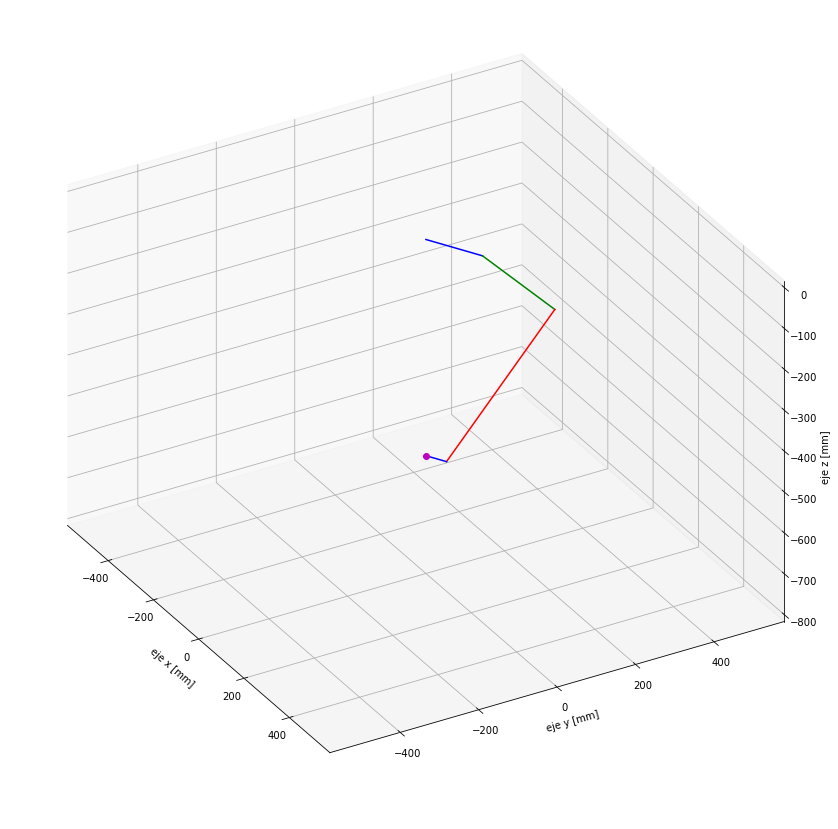

In [58]:
fig1 = plt.figure(figsize=(15, 15))
ax = fig1.add_subplot(111,projection = '3d', proj_type = 'ortho')

ax.view_init(elev=30, azim=330)

#Gráfica de cadena cinemática 1 (brazo 1)
ax.plot([D1x,0],[D1y,0],[D1z,0],'-b')
h_a1 = ax.plot([D1x,Q1x],[D1y,Q1y],[D1z,Q1z],'-g')
h_b1 = ax.plot([C1x,Q1x],[C1y,Q1y],[C1z,Q1z],'-r')
h_h1 = ax.plot([C1x,px],[C1y,py],[C1z,pz],'-b')
# #Graficar cadena cinemática 2 (brazo 2) aquí

# #Graficar cadena cinemática 3 (brazo 3) aquí


h_P = ax.plot([px],[py],[pz],'mo',linewidth = 2)
fEscala = 1.39
ax.set_xlim3d(-400*fEscala,400*fEscala)
ax.set_ylim3d(-400*fEscala,400*fEscala)
ax.set_zlim3d(-800,0)
ax.set_xlabel("eje x [mm]")
ax.set_ylabel("eje y [mm]")
ax.set_zlabel("eje z [mm]")

### Solución para las otras cadenas cinemáticas

Actividad propuesta: ¿qué se debe definir para encontrar la posición de las otras dos cadenas?

pista: $\phi$ y $Q$

## Trayectorias

El objetivo del robot es realizar trabajos. Esto se logra desplazando el punto de interés P por el espacio, de manera que la herramienta que tenga de momento logre posicionarse donde se necesita. Esto en términos cinemáticos se traduce a definir trayectorias que el punto P debe recorrer.

Una trayectoria se compone de un conjunto de coordenadas sucesivas. Debemos especificar las trayectorias de manera que no haya una distancia muy amplia entre los puntos que la componen. 

Para más información sobre la construcción de trayectorias, revisar el siguiente cuaderno:

https://nbviewer.org/github/luismiguelaristi/MecanismosPythonUPB/blob/main/03a_Delta/03_Trayectorias/RobotDelta_Trayectorias.ipynb

Usando dicho cuaderno, podemos generar un archivo que contenga la trayectoria. En este ejemplo, usaremos el siguiente archivo de trayectoria:

[Descargar archivo aquí](./trayectoria)

El archivo de trayectoria se debe ubicar en la misma carpeta donde esté ubicado este cuaderno. Si se requiere una ubicación específica, se debe definir en los argumentos de *open()*

In [59]:
import pickle
with open("trayectoria", "rb") as f:
    [[pxv],[pyv],[pzv]] = pickle.load(f)

numpos = np.size(pxv)
pxv,pyv,pzv

(array([   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    5.12820513,   10.25641026,   15.38461538,
          20.51282051,   25.64102564,   30.76923077,   35.8974359 ,
          41.02564103,   46.15384615,   51.28205128,   56.41025641,
          61.53846154,   66.66666667,   71.79487179,   76.92307692,
          82.05128205,   87.17948718,   92.30769

Grafiquemos la trayectoria

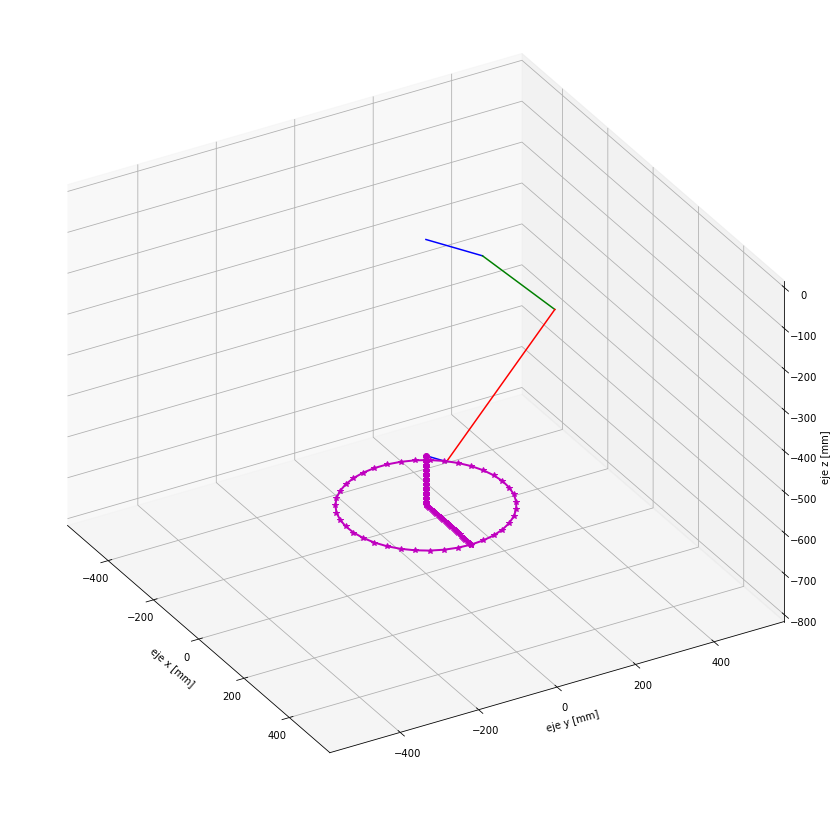

In [60]:
ax.plot(pxv,pyv,pzv,'-*m',linewidth = 2)
fig1

También debemos definir la posición de todos los puntos que se mueven en el mecanismo, es decir, los puntos $C$ y $Q$. El último lo debemos hallar con la solución de las ecuaciones, mientras que el primero es conocido ya que depende de $P$:

In [61]:
C1xv = pxv + h*np.cos(phi)
C1yv = pyv + h*np.sin(phi)
C1zv = pzv

Luego resolvemos para todas las posiciones *numpos* de la trayectoria

In [62]:
EXITFLAG = np.zeros(numpos)
Q1xv = np.zeros(numpos)
Q1yv = np.zeros(numpos)
Q1zv = np.zeros(numpos)

for i in range(0,numpos):
    parametros[0] = pxv[i]
    parametros[1] = pyv[i]
    parametros[2] = pzv[i]
    Y,info,EXITFLAG[i],msg = fsolve(fn_delta,x0,args = parametros,full_output = True)
    x0 = Y
    Q1xv[i] = Y[0];
    Q1yv[i] = Y[1];
    Q1zv[i] = Y[2];
    if EXITFLAG[i] != 1:
        print("Error en la iteración ",i,". msg = ", msg)
        break
    
# Q1xv,Q1yv,Q1zv

si todo salió bien, podemos proceder con la animación.

In [63]:
def animar(i):
    brazo1_X = np.array([D1x,Q1xv[i]])
    brazo1_Y = np.array([D1y,Q1yv[i]])
    brazo1_Z = np.array([D1z,Q1zv[i]])
    antebrazo1_X = np.array([C1xv[i],Q1xv[i]])
    antebrazo1_Y = np.array([C1yv[i],Q1yv[i]])
    antebrazo1_Z = np.array([C1zv[i],Q1zv[i]])
    bmovil1_X = np.array([C1xv[i],pxv[i]])
    bmovil1_Y = np.array([C1yv[i],pyv[i]])
    bmovil1_Z = np.array([C1zv[i],pzv[i]])
    h_a1[0].set_data_3d([brazo1_X,brazo1_Y,brazo1_Z])
    h_b1[0].set_data_3d([antebrazo1_X,antebrazo1_Y,antebrazo1_Z])
    h_h1[0].set_data_3d([bmovil1_X,bmovil1_Y,bmovil1_Z])
    h_P[0].set_data_3d([pxv[i],pyv[i],pzv[i]])
    
    # Agregar los objetos gráficos a esta línea de return (evita error en spyder)
    return h_a1[0],h_b1[0],h_h1[0],h_P[0]

### Configuración de la animación

Las animaciones de movimiento del robot Delta suelen ser largas, por lo cual generan archivos pesados. A continuación podemos modificar las características de la animación resultante:

In [64]:
videoLength = 5000 # en milisegundos
maxFrames = 50 # menos implica más liviana, pero menos fluidez
fig1.set_dpi(50) #Resolución de la figura
increment = int(np.ceil(numpos/maxFrames))
totalFrames = range(0,numpos,increment)
animacion = FuncAnimation(fig1, animar, frames = totalFrames,
                          interval=videoLength/len(totalFrames), save_count=len(totalFrames),blit=True)

from IPython.display import HTML
#En Jupyter se pueden mostrar las animaciones directamente en el cuaderno
#Esta alternativa hace que el cuaderno quede muy pesado si la animación es larga
# Comentar para reducir tamaño del cuaderno
HTML(animacion.to_jshtml())
# Descomentar para generar animación en formato gif o mp4, requiere instalar ffmpeg
#animacion.save('animation.gif', writer='Pillow', fps=15)
#animacion.save('animation.mp4', writer='ffmpeg', fps=15)

## Exportar ángulos para programación de robot

¿Cómo encontrar el ángulo $\theta$ si se conoce la ubicación del punto $Q$?

$\theta = $

Ahora aplicamos esto a los tres brazos, para así hallar $\theta_1,\theta_2$ y $\theta_3$.

Nota: deben especificarse en grados para poder ser ingresados al programa del robot real.

In [66]:
th1v = np.zeros(numpos)
# th2v = 
# th3v = 

datos = np.transpose([th1v]) #,th2v,th3v])
#.csv - archivo de valores separados por comas (comma separated values)
np.savetxt("angulos.csv", datos,fmt='%.3f', delimiter=",")
datos

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

## Verificación de límites

Se debe verificar que los ángulos $\theta_1,\theta_2$ y $\theta_3$ No excedan los limites [-85°,-20°]

In [ ]:
fig2,ax = plt.subplots(figsize=(15,5))
ax.plot([0,numpos],[-20,-20])
ax.plot([0,numpos],[-85,-85])
ax.set_title("Posición angular de los motores")
ax.set_xlabel("punto de trayectoria")
ax.set_ylabel("posición angular [°]")
ax.grid()
ax.plot(th1v,'.r')
# ax.plot(th2v,'.g')
# ax.plot(th3v,'.b')
ax.legend(["límite sup.","límite inf.","$\\theta_1$","$\\theta_2$","$\\theta_3$"])
